# Notebook 8: Phase 4 - Robustness & Interpretability

**Goals**:
1.  **Rolling Cross-Validation**: Address the "Short Data" concern by testing model stability across multiple time splits (not just 2015).
2.  **Residual Analysis**: Check statistical assumptions (Normality, Autocorrelation) of our Champion Linear Model.
3.  **Feature Importance**: Identify what actually drives CO2 emissions in our model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.stattools import durbin_watson
import json
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

TARGET = 'Value_co2_emissions_kt_by_country'

# Load Data
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')

# Restore Year/Entity if missing
if 'Year' not in df_lr.columns: 
    df_lr['Year'] = df_common.loc[df_lr.index, 'Year']
if 'Entity' not in df_lr.columns: 
    df_lr['Entity'] = df_common.loc[df_lr.index, 'Entity']
    
# Load Clusters (from Phase 3 v2 logic - simplified for this notebook)
# We will just re-run the cluster mapping logic quickly to ensure consistency
SPLIT_YEAR_TRAINING_PROFILE = 2015
cluster_cols = ['gdp_per_capita', 'Access to electricity (% of population)', 
                'Renewable energy share in the total final energy consumption (%)', 
                'Primary energy consumption per capita (kWh/person)']
df_profile = df_common[df_common['Year'] < SPLIT_YEAR_TRAINING_PROFILE].groupby('Entity')[cluster_cols].mean().dropna()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)
kmeans = KMeans(n_clusters=3, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)
df_lr['Cluster'] = df_lr['Entity'].map(df_profile['Cluster'])
df_lr.dropna(subset=['Cluster'], inplace=True)

# Load Best Params
with open('../data/results/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)
params_lr = best_params.get('Linear Regression', {})

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 25)
Loaded data from ../data/processed/lr_final_prep.csv: (2190, 193)


## 1. Rolling Window Cross-Validation
Instead of a single split at 2015, we define a "Walking Forward" Validation:
- Train: 2000-2014 | Test: 2015
- Train: 2000-2015 | Test: 2016
- ...
- Train: 2000-2018 | Test: 2019

This checks if the model performance is consistent over time.

Performing Rolling Window Evaluation (Cluster-Based LR)...
Train <= 2014, Test 2015: R2 = 0.9692


Train <= 2015, Test 2016: R2 = 0.9884


Train <= 2016, Test 2017: R2 = 0.9595
Train <= 2017, Test 2018: R2 = 0.9839
Train <= 2018, Test 2019: R2 = 0.9889
Train <= 2019, Test 2020: R2 = 0.9915


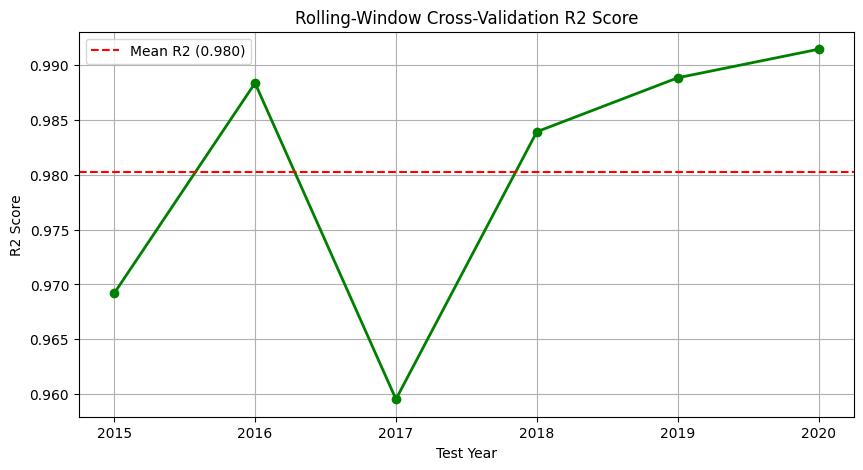

In [2]:
years = sorted(df_lr['Year'].unique())
start_window = 2014
rolling_results = []

print("Performing Rolling Window Evaluation (Cluster-Based LR)...")

for split_year in range(start_window, 2020):
    # Define Train/Test based on Current Split Year
    train = df_lr[df_lr['Year'] <= split_year]  # Expanding Window
    test = df_lr[df_lr['Year'] == (split_year + 1)] # Predict Next Year
    
    if len(test) == 0: continue

    drop_cols = [TARGET, 'Year', 'Cluster', 'Entity']
    drop_cols = [c for c in drop_cols if c in df_lr.columns]
    
    # Train Cluster Models
    y_true_all = []
    y_pred_all = []
    
    for cluster in df_lr['Cluster'].unique():
        c_train = train[train['Cluster'] == cluster]
        c_test = test[test['Cluster'] == cluster]
        
        if len(c_test) == 0: continue
            
        X_tr = c_train.drop(columns=drop_cols)
        y_tr = c_train[TARGET]
        X_te = c_test.drop(columns=drop_cols)
        y_te = c_test[TARGET]
        
        model = Ridge(**params_lr)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        
        y_true_all.extend(y_te)
        y_pred_all.extend(preds)
        
    # Calculate Global Metric for this Year
    year_r2 = r2_score(y_true_all, y_pred_all)
    rolling_results.append({'Test_Year': split_year + 1, 'R2': year_r2})
    print(f"Train <= {split_year}, Test {split_year+1}: R2 = {year_r2:.4f}")

df_rolling = pd.DataFrame(rolling_results)

plt.figure(figsize=(10, 5))
plt.plot(df_rolling['Test_Year'], df_rolling['R2'], marker='o', linestyle='-', linewidth=2, color='green')
plt.axhline(df_rolling['R2'].mean(), color='red', linestyle='--', label=f'Mean R2 ({df_rolling["R2"].mean():.3f})')
plt.title('Rolling-Window Cross-Validation R2 Score')
plt.xlabel('Test Year')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/rolling_cv_r2.png')
plt.show()

## 2. Residual Analysis
Are the errors random (Noise) or is there a pattern (Bias)?
We analyze residuals from the Phase 1 split (Test >= 2015).

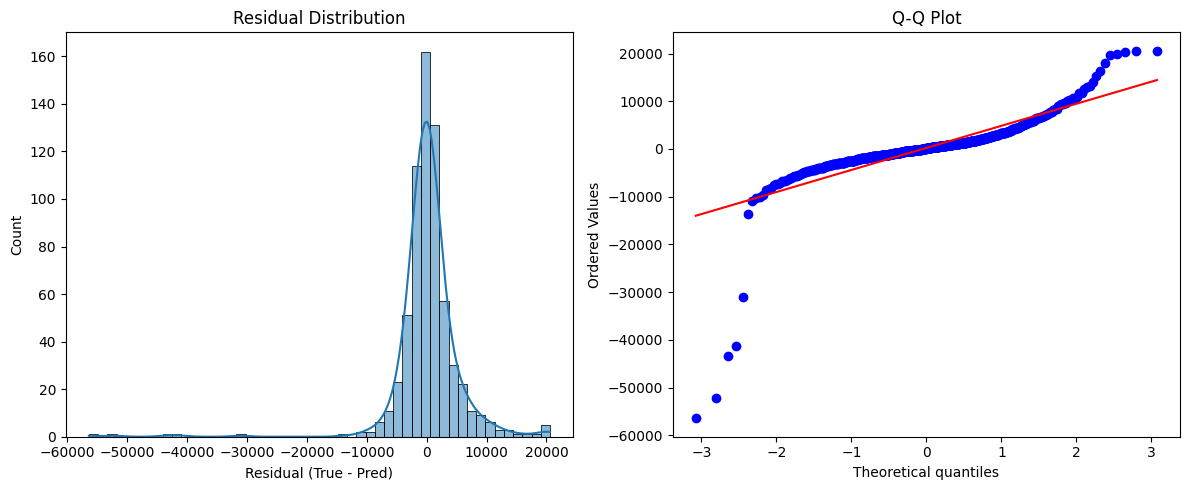

Durbin-Watson Score: 1.2134 (Ideal: ~2.0)


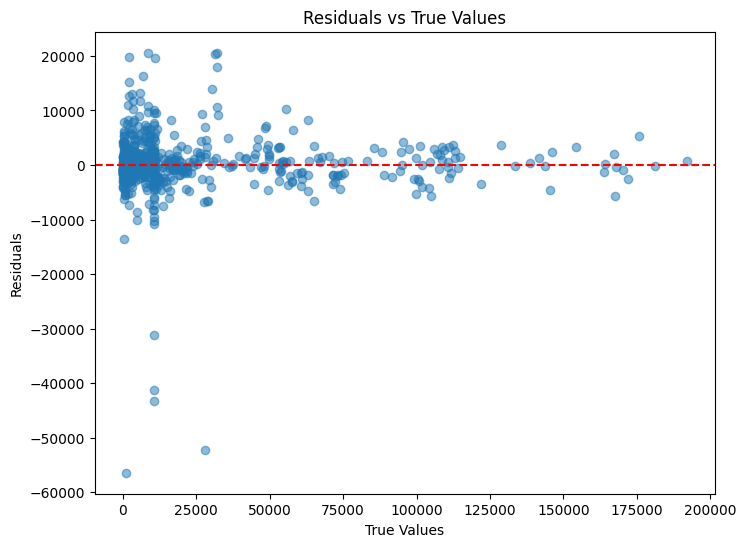

In [3]:
# Re-run Single Split (Phase 3 v2 style) to get Residuals
train_full = df_lr[df_lr['Year'] < 2015]
test_full = df_lr[df_lr['Year'] >= 2015]

drop_cols = [TARGET, 'Year', 'Cluster', 'Entity']
drop_cols = [c for c in drop_cols if c in df_lr.columns]

residuals = []

for cluster in df_lr['Cluster'].unique():
    c_train = train_full[train_full['Cluster'] == cluster]
    c_test = test_full[test_full['Cluster'] == cluster]
    
    if len(c_test) == 0: continue
        
    model = Ridge(**params_lr)
    model.fit(c_train.drop(columns=drop_cols), c_train[TARGET])
    preds = model.predict(c_test.drop(columns=drop_cols))
    
    res = c_test[TARGET] - preds
    residuals.extend(res)

residuals = np.array(residuals)

# 2A. Distribution of Residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=50)
plt.title('Residual Distribution')
plt.xlabel('Residual (True - Pred)')

# 2B. Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.tight_layout()
plt.savefig('../reports/figures/residual_analysis.png')
plt.show()

# 2C. Durbin-Watson (Autocorrelation)
# DW ~ 2.0 means No Autocorrelation. 0-2 (Positive), 2-4 (Negative)
dw_score = durbin_watson(residuals)
print(f"Durbin-Watson Score: {dw_score:.4f} (Ideal: ~2.0)")

# 2D. Residuals vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(test_full[TARGET], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.savefig('../reports/figures/residuals_vs_true.png')
plt.show()

## 3. Feature Importance
Which features drive the Linear Model?

/tmp/ipykernel_18569/2409917676.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_10, palette='viridis')


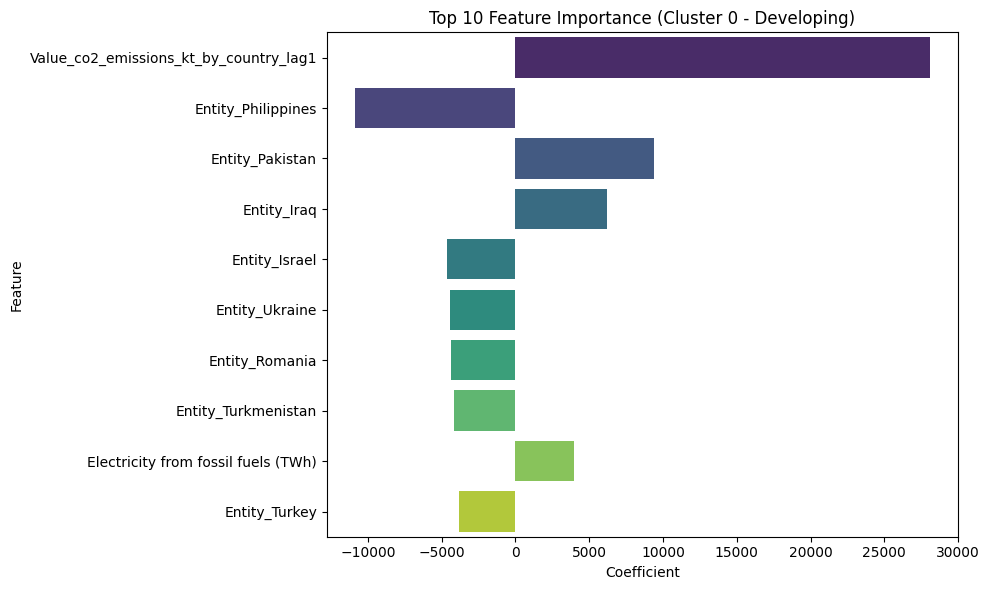

Top Features:
                                    Feature   Coefficient
14   Value_co2_emissions_kt_by_country_lag1  28064.265882
142                      Entity_Philippines -10837.753004
137                         Entity_Pakistan   9406.115882
92                              Entity_Iraq   6194.670735
94                            Entity_Israel  -4669.815258
182                          Entity_Ukraine  -4400.892948
147                          Entity_Romania  -4382.447028
179                     Entity_Turkmenistan  -4164.412574
3       Electricity from fossil fuels (TWh)   3989.695919
178                           Entity_Turkey  -3791.492671


In [4]:
# We fit on the whole dataset to interpret global drivers (or per cluster)
# Let's look at Cluster 0 (Developing) which had best performance

cluster_id = 0
data_c = df_lr[df_lr['Cluster'] == cluster_id]
cols = data_c.drop(columns=drop_cols).columns
model = Ridge(**params_lr)
model.fit(data_c.drop(columns=drop_cols), data_c[TARGET])

coefs = pd.DataFrame({
    'Feature': cols,
    'Coefficient': model.coef_,
    'Abs_Coef': np.abs(model.coef_)
}).sort_values('Abs_Coef', ascending=False)

top_10 = coefs.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_10, palette='viridis')
plt.title(f'Top 10 Feature Importance (Cluster {cluster_id} - Developing)')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance_c0.png')
plt.show()

print("Top Features:")
print(top_10[['Feature', 'Coefficient']])